In [1]:
import torch
import csv
import os
import random
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
import pandas as pd
from dataset_reader import Traces_Dataset
from mlp_model import MLP
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import uuid

In [2]:
# initialize a dictionary of training history to store in a csv file
history_dict = {}

unique_id = str(uuid.uuid4())[:8]
history_dict['unique_id'] = unique_id
print(f'Experiment ID: {unique_id}')

Experiment ID: 6eabb4e5


In [3]:
# making training reproducible
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
history_dict['seed'] = seed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Uncomment this line
print(f"Using device: {device}")

Using device: cuda


In [4]:
# load and process dataset 
dataset = Traces_Dataset('dataset_exp.csv')
print(dataset.inputs.shape)
dataset.split_dataset(0.95, 0.05, 0)
dataset.clean_features()
dataset.find_mean_std()
dataset.normalize()
print(dataset.inputs.shape)
history_dict['normalize_mean'] = dataset.train_mean.tolist()
history_dict['normalize_std'] = dataset.train_std.tolist()
history_dict['dataset'] = (dataset.inputs.shape[0], dataset.inputs.shape[1])

torch.Size([776000, 442])
torch.Size([776000, 431])


In [5]:
dataset.inputs.shape, dataset.params.shape

(torch.Size([776000, 431]), torch.Size([776000, 7]))

In [6]:
# initialize train, val, test set
X_train = dataset[dataset.train_set.indices][0]
Y_train = dataset[dataset.train_set.indices][1]

X_val = dataset[dataset.val_set.indices][0]
Y_val = dataset[dataset.val_set.indices][1]

X_test = dataset[dataset.test_set.indices][0]
Y_test = dataset[dataset.test_set.indices][1]

# initialize NN model
model = MLP(dataset.inputs.shape[1], dataset.params.shape[1]).to(device)
model.initialize_weights()

In [7]:
# store model architecture
architecture = []
for name, layer in model.named_children():
    architecture.append(layer)
history_dict['architecture'] = architecture
architecture

[Sequential(
   (0): Linear(in_features=431, out_features=512, bias=True)
   (1): SiLU()
   (2): Linear(in_features=512, out_features=512, bias=True)
   (3): SiLU()
   (4): Linear(in_features=512, out_features=7, bias=True)
 )]

In [8]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.001) 

# record optimizer
lr = optimizer.param_groups[0]['lr']
history_dict['optimizer'] = f'{optimizer.__class__.__name__} {lr}'
history_dict['optimizer']

'Adam 0.001'

In [9]:
# functions to save and load best nn model, and create an unique id to store the model
def checkpoint(model, filename, folder='models'):
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, filename)
    torch.save(model.state_dict(), filepath)
    return filepath
def resume(model, filepath):
    model.load_state_dict(torch.load(filepath))

In [10]:
# this is a 1d vector containing all weight in the nn model, no bias included. 
def weights_1d(model): 
    # Get parameters with gradients
    parameters_with_grad = [param for param in model.parameters() if param.requires_grad]
    # Concatenate parameters into a 1D tensor
    flat_parameters = torch.cat([param.view(-1) for param in parameters_with_grad])
    return flat_parameters
print(f'Number of model parameters: {weights_1d(model).shape[0]}')
weights_change_updates = np.array([])  # using numpy array to save memory 
weights_change_epochs = []

Number of model parameters: 487431


In [11]:
# training parameters
n_epochs = 300   # number of epochs to run
batch_size = 1024  # size of each batch
history_dict['epochs'] = n_epochs
history_dict['batch size'] = batch_size

In [12]:
# initialize dataloader 
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, Y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# initialization train, val losses
train_losses = []
val_losses = []

best_validation_loss = float('inf')

In [13]:
# record the weights with no training
# with torch.no_grad():
#     previous_weights_epoch = weights_1d(model)

# Training loop
for epoch in range(1, n_epochs + 1):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # record the weights changes across each updates (batches)
        # with torch.no_grad():
        #     current_weights = weights_1d(model)
        #     if 'previous_weights' in locals():
        #         weight_change = torch.norm(current_weights - previous_weights).item()#.cpu()
        #         weights_change_updates = np.append(weights_change_updates, weight_change)
        #     previous_weights = current_weights

        total_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation during validation
        # record the weights change across epochs
        # current_weights_epoch = weights_1d(model)
        # if 'previous_weights_epoch' in locals():
        #     weight_change_epoch = torch.norm(current_weights_epoch - previous_weights_epoch).item()#.cpu()
        #     weights_change_epochs.append(weight_change_epoch)
        # previous_weights_epoch = current_weights_epoch

        # validation
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = loss_fn(val_outputs, val_labels)
            total_val_loss += val_loss.item()

    # Average validation loss for the epoch
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'{epoch}: train-{avg_train_loss}, val-{avg_val_loss}')

    # saving the model with best training mse
    # if len(train_losses) != 1:
    #     if avg_train_loss < train_losses[-2]: 
    #         best_loss = avg_train_loss
    #         best_epoch = epoch
    #         model_path = checkpoint(model, f"model_{unique_id}.pth")
    if avg_val_loss < best_validation_loss:
        best_epoch = epoch
        model_path = checkpoint(model, f"model_{unique_id}.pth")
        best_training_loss = avg_train_loss
        best_validation_loss = avg_val_loss

1: train-112.71570099724664, val-21.580206168325322
2: train-19.59459612104628, val-17.017973297520687
3: train-14.623048149214851, val-12.371798339642977
4: train-9.256521307759815, val-7.281983475936086
5: train-6.764703277746836, val-5.882092701761346
6: train-5.35810061428282, val-4.704112906205027
7: train-4.408255284362369, val-3.491073150383799
8: train-3.880662476685312, val-3.4359918519070276
9: train-3.4603785809543397, val-4.551704318899858
10: train-3.020250927077399, val-2.47310241272575
11: train-2.766701895329687, val-1.9430078424905475
12: train-2.6250678380330403, val-2.816089234854046
13: train-2.5119232391317685, val-2.0337778643557898
14: train-2.290079507893986, val-1.6417778228458606
15: train-2.1357098071111573, val-2.119119383786854
16: train-2.055517697830995, val-2.271594135384811
17: train-2.0517219689157273, val-2.5442793432034945
18: train-1.9341132558882237, val-1.6967507569413436
19: train-1.9112211915353934, val-1.912658111045235
20: train-1.814178889493

In [14]:
# record training, validationg losses, weight updates, and the result model path
history_dict['best_epoch'] = best_epoch
history_dict['best_val'] = best_validation_loss
history_dict['best_train'] = best_training_loss
history_dict['training'] = train_losses
history_dict['validation'] = val_losses
history_dict['weights'] = weights_change_epochs
history_dict['model'] = model_path

In [17]:
def experiment_records(row_data, file_path = 'experiment records.csv'): 
    '''
    row_data is a dictionary of the row_data we want to store
    '''
    # Check if the file exists
    file_exists = os.path.isfile(file_path)

    with open(file_path, mode='a' if file_exists else 'w', newline='') as csv_file:
        # Create a CSV writer object
        csv_writer = csv.writer(csv_file)

        # If the file is newly created, write the header row
        if not file_exists:
            header_row = row_data.keys() if isinstance(row_data, dict) else row_data
            csv_writer.writerow(header_row)

        # Write the data row
        if isinstance(row_data, dict):
            csv_writer.writerow(row_data.values())
        else:
            csv_writer.writerow(row_data)

In [18]:
experiment_records(history_dict)

In [19]:
print(f"Best validation loss: {best_validation_loss}, at epoch: {best_epoch}")
#print("RMSE: %.2f" % np.sqrt(best_mse))
print('Number of total training samples: ', X_train.shape[0])

Best validation loss: 0.1272017291109813, at epoch: 294
Number of total training samples:  737200


(0.0, 2.0)

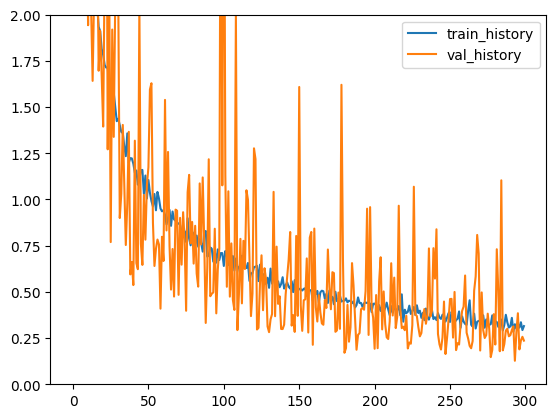

In [23]:
plt.plot(train_losses, label='train_history')
plt.plot(val_losses, label = 'val_history')
plt.legend()
plt.ylim(0, 2)

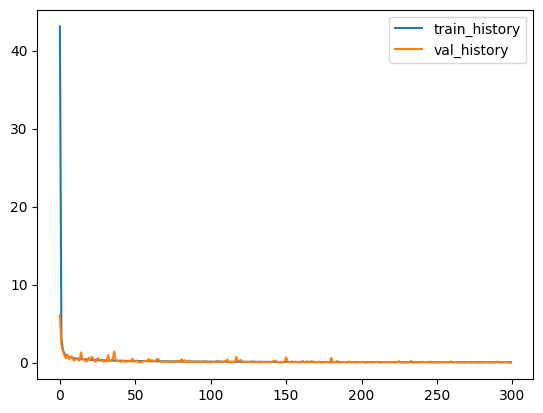

In [20]:
os.makedirs('train_figures', exist_ok=True)
plt.figure()  # Create a new figure
plt.plot(train_losses, label='train_history')
#plt.plot(train_loss_history, label='train_history')
plt.plot(val_losses, label = 'val_history')
plt.legend()
#plt.ylim(100, 300)
#plt.xlim(0,10)
plt.savefig(f'train_figures/{unique_id}.png')

# os.makedirs('weights_figures', exist_ok=True)
# plt.figure()  # Create a new figure
# plt.plot(weights_change_updates, label = 'norm_weights_diff') 
# plt.xlabel('Epoch')
# plt.ylabel('Norm of diff in model weights across batch updates')
# plt.legend()
# plt.savefig(f'weights_figures/updates {unique_id}.png')

# plt.figure()  # Create a new figure
# plt.plot(weights_change_epochs, label = 'norm_weights_diff') 
# plt.xlabel('Epoch')
# plt.ylabel('Norm of diff in model weights across epochs')
# plt.legend()
# plt.savefig(f'weights_figures/epochs {unique_id}.png')

# print(train_losses)
# print(weights_change_epochs)

Test the model

In [27]:
resume(model, f'models/model_{unique_id}.pth')
model.cpu()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=429, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): SiLU()
    (4): Linear(in_features=512, out_features=7, bias=True)
  )
)

In [39]:
test_sample = 13407
model(X_val[test_sample]).detach(), Y_val[test_sample]

(tensor([  0.9303, 137.5029, -63.6215,   0.8221,  22.4191,   0.5264, -14.9443]),
 tensor([  1.0000, 137.7803, -63.5929,   0.8495,  22.3191,   0.4920, -14.9882]))

In [51]:
X_train.shape[0]

1696700

In [29]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('experiment records.csv')

df

,unique_id,seed,normalize_mean,normalize_std,dataset,architecture,optimizer,epochs,batch size,best_epoch,best_val,best_train,training,validation,weights,model
0,45c4bad6,42,"[0.008891306817531586, 0.013731910847127438, 0...","[0.012370031327009201, 0.016995912417769432, 0...","torch.Size([1786000, 429])","[Sequential(\n (0): Linear(in_features=429, o...",Adam 0.001,300,1024,258,0.029846,0.080799,"[31.792827115982647, 2.3219674535378965, 1.444...","[8.479385934092782, 0.9476684358986941, 0.5425...",[],models/model_45c4bad6.pth
1,b292ea70,42,"[0.008891306817531586, 0.013731910847127438, 0...","[0.012370031327009201, 0.016995912417769432, 0...","(1786000, 429)","[Sequential(\n (0): Linear(in_features=429, o...",Adam 0.001,300,1024,230,0.025296,0.070175,"[43.09805644616062, 3.1102608075398024, 1.6109...","[6.09941353039308, 2.2470590323209763, 1.44377...",[],models/model_b292ea70.pth
